# Jet Tagging with Convolutional Neural Networks (CNN)

This notebook show how to use a CNN for jet classification between QCD and TT jets using jet images.

## What is a CNN?
A Convolutional Neural Network (CNN) is a type of neural network designed to process grid-like data, such as images. It uses convolutional layers to learn spatial patterns.

## Why use CNNs for Jet Tagging?
- Natural for processing jet images
- Can learn spatial patterns in energy deposits
- Translation invariant
- Parameter efficient

In [1]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import F1Score
from tensorflow.keras import Input
from jet_utils import load_images, preprocess_jet_images
from jet_plotting_utils import plot_jet_image, plot_training_history, plot_confusion_matrix, plot_roc_curve

2025-07-25 13:25:29.183854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753449929.448705      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753449929.520334      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Load and Prepare Data

We'll use the jet images directly as input to our CNN. Each image represents the energy deposits in the η-φ plane.

In [2]:
X_train, y_train, train_ids, X_val_, y_val, val_ids, X_test, test_ids = load_images()

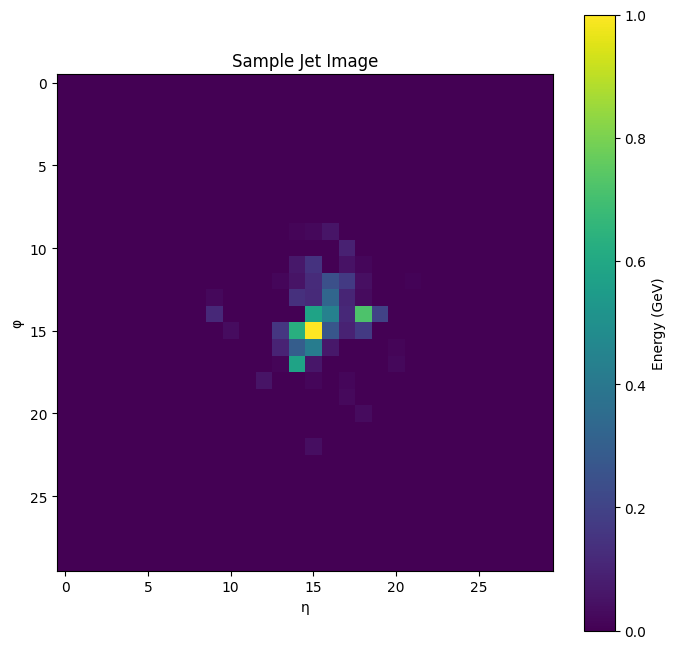

jet_2294
0.0


In [3]:
# Visualize a sample jet image
plot_jet_image(X_train[1943, :, :], "Sample Jet Image")#
print(train_ids[3143 ])
print(y_train[3143])

## 2. Build CNN Model

We'll create a CNN with:
- Convolutional layers to learn spatial patterns
- MaxPooling layers to reduce spatial dimensions
- Dense layers for classification
- Dropout for regularization

In [11]:
dropout = 0.2
kernel_size = 5
max_pool_size = 2
#leaky_relu_alpha = 0.1

def build_deep_cnn_model(input_shape):
    
    model = keras.Sequential([
        # Input layer
        keras.layers.Input(shape=input_shape),

        # --- Convolutional Base ---

        #keras.layers.Conv2D(32, (kernel_size, kernel_size), padding='same', activation='relu'),
        keras.layers.Conv2D(32, (kernel_size, kernel_size), padding='same', activation = 'relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((max_pool_size, max_pool_size)),

        # Block 2
        keras.layers.Conv2D(64, (kernel_size, kernel_size), padding='same', activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((max_pool_size, max_pool_size)),

        # Block 3
        keras.layers.Conv2D(128, (kernel_size, kernel_size), padding='same', activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((max_pool_size, max_pool_size)),
        
        # Block 4 (Deeper)
        keras.layers.Conv2D(256, (kernel_size, kernel_size), padding='same', activation='relu',),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((max_pool_size, max_pool_size)),

        # --- Classifier Head ---

        # Flatten the feature maps into a single vector
        keras.layers.Flatten(),
        
        # Dense Layer 1
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(dropout),

        # Dense Layer 2 (Deeper)
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(dropout),

        # Output Layer
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-4) 
    #optimizer = Adam(learning_rate = 1e-3)
    #f1 = F1Score(threshold=0.5)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=["accuracy"])
    
    return model


model = build_deep_cnn_model(X_train.shape[1:])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 3, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,178,753 (4.50 MB)

 Trainable params: 1,177,025 (4.49 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [5]:
"""def build_cnn_model(input_shape):
    model = keras.Sequential([
        # First convolutional block
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Third convolutional block
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Flatten and dense layers
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

# Create and compile model
model = build_cnn_model(X_train.shape[1:])
model.summary()
"""

"def build_cnn_model(input_shape):\n    model = keras.Sequential([\n        # First convolutional block\n        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),\n        keras.layers.MaxPooling2D((2, 2)),\n        \n        # Second convolutional block\n        keras.layers.Conv2D(64, (3, 3), activation='relu'),\n        keras.layers.MaxPooling2D((2, 2)),\n        \n        # Third convolutional block\n        keras.layers.Conv2D(64, (3, 3), activation='relu'),\n        \n        # Flatten and dense layers\n        keras.layers.Flatten(),\n        keras.layers.Dense(64, activation='relu'),\n        keras.layers.Dropout(0.5),\n        keras.layers.Dense(1, activation='sigmoid')\n    ])\n    \n    model.compile(optimizer='adam',\n                 loss='binary_crossentropy',\n                 metrics=['accuracy'])\n    \n    return model\n\n# Create and compile model\nmodel = build_cnn_model(X_train.shape[1:])\nmodel.summary()\n"

In [6]:
X_train.shape

(3520, 30, 30, 1)

## 3. Train Model

We'll train the CNN with:
- Early stopping to prevent overfitting
- Validation split to monitor performance
- Batch size of 32 for stable training

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6290 - loss: 0.7464 - val_accuracy: 0.3456 - val_loss: 0.7566
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8492 - loss: 0.4054 - val_accuracy: 0.3456 - val_loss: 0.7171
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8653 - loss: 0.3726 - val_accuracy: 0.6544 - val_loss: 0.6611
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8684 - loss: 0.3483 - val_accuracy: 0.6544 - val_loss: 0.8074
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8864 - loss: 0.3292 - val_accuracy: 0.6544 - val_loss: 1.0624
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8897 - loss: 0.3236 - val_accuracy: 0.6600 - val_loss: 1.1103
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8948 - loss: 0.2995 - val_accuracy: 0.6837 - val_loss: 0.9700
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8918 - loss: 0.2900 - val_accuracy: 0.7538 - val_loss

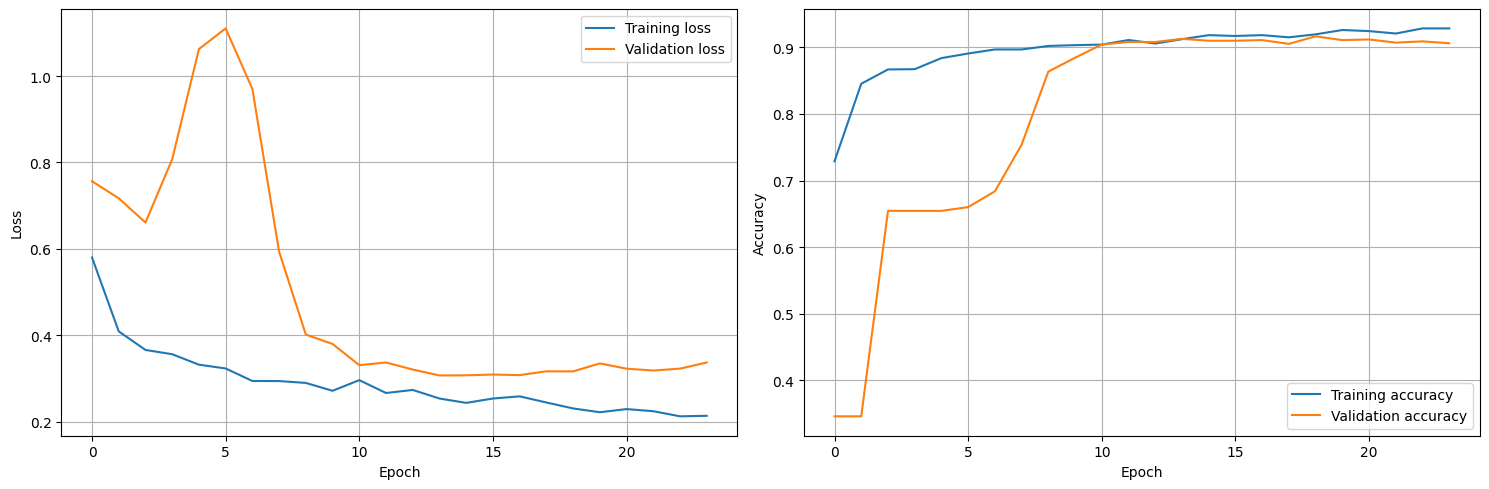

In [12]:
# Train model
#y_train = y_train.reshape(-1, 1)


history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.3
,    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

# Plot training history
plot_training_history(history)

## 4. Evaluate Model

Let's evaluate our model's performance on the test set.

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9150 - loss: 0.3635 
Test Accuracy: 0.9004
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


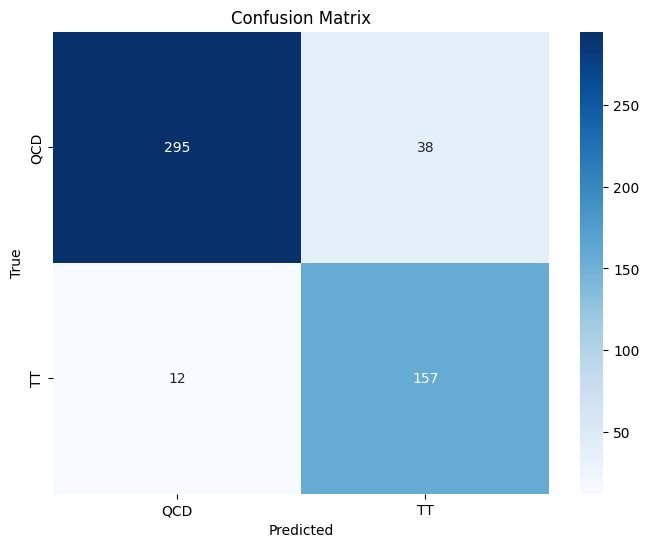

In [13]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_val_, y_val)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_val_)
y_pred_discrete = (y_pred > 0.5).astype(int)
# Plot confusion matrix
plot_confusion_matrix(y_val, y_pred_discrete)

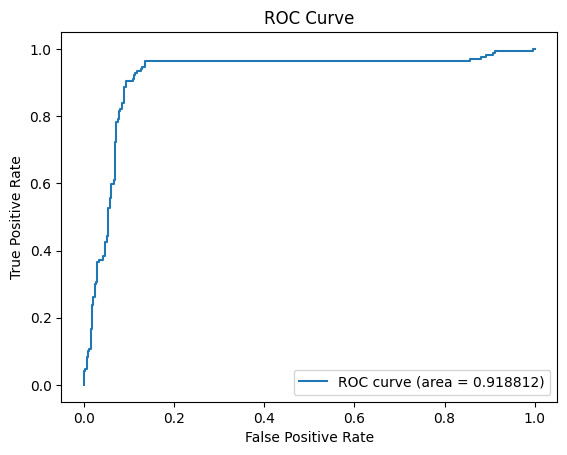

In [14]:
plot_roc_curve(y_val, y_pred)

# 5 - Making predictions

In [136]:
import pandas as pd 
test_predictions = model.predict(X_test)[:,0]
print(test_predictions.shape)
print(test_ids.shape)
solution = pd.DataFrame({'id':test_ids, 'label':test_predictions})
solution.to_csv('submission.csv', index = False)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
(1005,)
(1005,)
